# Project 1: Centrality Measures - New York Subway System

Data 620 Week 5

*March 6, 2022*

*By Alexander Ng and Philip Tanofsky*



# Section 1: Introduction

The New York City Subway is the most extensive rapid transit system in the world with 472 stations.  It delivered 1.72 billion rides a year in 2017 and is the busiest system in the Western world.
[List of metro systems](https://en.wikipedia.org/wiki/List_of_metro_systems).   The system runs through all five boroughs: Brooklyn, Bronx, Manhattan, Queens and Staten Island and runs 24/7 except during emergencies. [New York City Subway](https://en.wikipedia.org/wiki/New_York_City_Subway)


<img src="https://upload.wikimedia.org/wikipedia/commons/2/23/Official_New_York_City_Subway_Map_2013_vc.jpg" />

In this study, we will examine two questions related to subway network centrality.

In Part 4, we consider how network centrality affected station level ridership declines between 2018 before the Covid-pandemic to 2020 when Covid reduced ridership to historic lows.  Using the borough of each station as a categorical attribute, do we see variations in ridership declines that could be explain by remoteness?  For example, do the outer borough declines occur less because of fewer transportation options in outer Queens or Brooklyn compared to Manhattan?   Alexander Ng is the primary author of this section.

In Part 5, we explore how the subway network relates to the city's wealth distribution.   For example, how does subway network centrality measures compare to the household median income near each station?   By bucketing household median income into local quartiles, we construct low, moderate, high, very high income categories. Philip Tanofsky is the primary author of this section.

# Section 2: NYC Subway Network Construction
## Step 1: Build the Subway Files

This phase of Project 1 constructs the NYC subway graph from the GTFS data files provided by the Metropolitan Transit Authority in the latest available dataset (as of Dec 2021).  The GTFS data files are text files with comma separated fields per row.  However, figuring out the nodes and edges is complicated by  domain specific issues because the purpose of the GTFS data files is not to build graphs but to support scheduling and operations.

### Stops

We begin by defining the nodes which represent subway stations.  This data is stored in the file `stops.txt`.   We load the data and inspect the first 5 rows.

In [305]:
# Import the basic libraries

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import json
from shapely.geometry import shape, GeometryCollection, Point
import geopy.distance
import warnings
warnings.filterwarnings('ignore')

In [306]:
data_dir = "google_transit/"

stops_file = data_dir + "stops.txt"
stops_df = pd.read_csv(stops_file)
all_stops = stops_df[["stop_id", "stop_name", "stop_lat", "stop_lon", "location_type", "parent_station"]]
all_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1,NaN
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
3,103,238 St,40.884667,-73.900870,1,NaN
4,103N,238 St,40.884667,-73.900870,0,103


In the above `stops` dataset, each stop is listed 3 times as a `parent` and two `child` stops. 
Using stops `101`, `101N`, `101S` as a related example, we see that the parent stop `101` is identified by the field value `location_type`=`1` while `101N` (the northbound platform of the stop) and `101S` (the southbound platform of the stop) have `location_type` = `0` and use the field `parent_station` as a foreign key back to the `stop_id` of the parent stop `101` through self-join.   However, we'll need to retain the child stops `101N` and `101S` as the edges of our graph are defined in terms of child stops.   For simplicity, we select only essential columns in a dataframe `all_stops`.

### Routes

The `routes.txt` contains the names of the routes.  It is a reference file that defines the lines of services.  For example, A, B, C, 1, 2, 3, 4, 6, 7, etc.   Each route has several useful fields which we load into a dataframe:

*   `route_id` - integer identifier of the line - this is the primary key
*   `route_long_name` - describes the route's name is not unique.  E.g. 5 and 5X are both called Lexington Avenue Express.
*   `route_color` - the hex code color assigned to the line's livery on the map, subway cars and stations.  For example, $\color{#EE352E}{\text{Routes 1, 2, 3 use EE352E}}$.   Route colors are often grouped together.   Route colors may be viewed as edge attributes.


In [307]:
routes_file = data_dir + "routes.txt"
routes_df = pd.read_csv(routes_file)
all_routes = routes_df[["route_id", "route_long_name", "route_color"]]
all_routes.head()

,route_id,route_long_name,route_color
0,1,Broadway - 7 Avenue Local,EE352E
1,2,7 Avenue Express,EE352E
2,3,7 Avenue Express,EE352E
3,4,Lexington Avenue Express,00933C
4,5,Lexington Avenue Express,00933C


### Calendar

We load the list of available services.   A service associates a schedule of availability of multiple subway lines by day of week and holidays.   We are only going to use weekday services as an object to filter the set of trips as there are thousands of trips for each line with repetitive description of edges.

In [308]:
calendar_file = data_dir + "calendar.txt"
calendar_df = pd.read_csv(calendar_file)
all_calendar = calendar_df[["service_id", "start_date", "end_date"]]
all_calendar[ all_calendar["service_id"].str.contains("Weekday") ].head()

,service_id,start_date,end_date
23,AFA21GEN-1091-Weekday-00,20211220,20220624
24,AFA21GEN-2097-Weekday-00,20211220,20220624
25,AFA21GEN-3087-Weekday-00,20211220,20220624
26,AFA21GEN-4099-Weekday-00,20211220,20220624
27,AFA21GEN-5108-Weekday-00,20211220,20220624


### Trips

The `trips.txt` file joins three object types:  routes, services and trips.   Trips are the instances of services associated with a route containing a direction of travel (outbound or inbound).   The direction of travel is immaterial to our graph and we treat both directions as equivalent.   

*   `route_id` is a foreign key to the same column in `routes.txt`
*   `service_id` is a foreign key to the same column in `calendar.txt`

The `trip_id` is unique to the file and is in a one-to-many relationship with the `route_id` and `service_id` as it specifies the time of day when the trip is scheduled to begin its operation and the direction.

In [309]:
trips_file = data_dir + "trips.txt"
trips_df = pd.read_csv(trips_file)
all_trips = trips_df[["route_id", "service_id", "trip_id", "direction_id"]]

all_trips[ all_trips["service_id"].str.contains("Weekday") ].head()

,route_id,service_id,trip_id,direction_id
584,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_000650_1..S03R,1
585,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_002550_1..S03R,1
586,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_004550_1..S03R,1
587,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_006550_1..S03R,1
588,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_007450_1..N03R,0


### Stop Times

The file `stop_times.txt` contains the list of stops along with a sequence number of each trip listed in the trips file.
The essential information of each trip is the scheduled ordered sequence of stops.  Consecutive stops within an ordered sequence of the trip define the directed edges of a digraph.  Since we are interested in the undirected network, we will ignore the directionality of the edges when scanning the trips file.

In [310]:
stop_times_file = data_dir + "stop_times.txt"
stop_times_df = pd.read_csv(stop_times_file)
all_stop_times = stop_times_df[["trip_id", "stop_id", "stop_sequence" ]]

all_stop_times[ all_stop_times["trip_id"].str.contains("Weekday") ].head( )

,trip_id,stop_id,stop_sequence
22192,AFA21GEN-1091-Weekday-00_000650_1..S03R,101S,1
22193,AFA21GEN-1091-Weekday-00_000650_1..S03R,103S,2
22194,AFA21GEN-1091-Weekday-00_000650_1..S03R,104S,3
22195,AFA21GEN-1091-Weekday-00_000650_1..S03R,106S,4
22196,AFA21GEN-1091-Weekday-00_000650_1..S03R,107S,5


A unique key of  the `all_stop_times` dataframe are the two columns `trip_id`, `stop_sequence`.  We exploit this fact to build the edge list below.

## Step 2:  Constructing the Subway Network Graphs

To construct the network, we need to form equivalence classes of several GTFS object types.
We choose only one representative of multiple members of an equivalence class of object types with 2 strategies.

*   For nodes, we'll use only the parent node in our network.  

*   The edge information has even more members in the equivalence class.   For each two adjacent stops (nodes) in our graph,  multiple routes, multiple services and multiple trips may all include the two stops.   In other words, each directed edge could be listed dozens of times within the `all_stop_times` dataframe.
     +  In any edge, the order of nodes must be lexicographically increasing.   We will represent each edge as an ordered pair of parent stops.  For example, stops `101S` and `103S` are consecutive stops for trip `AFA21GEN-1091-Weekday-00_000650_1..S03R`.   
The corresponding edge is the pair `(101, 103)`.
     +  We will maintain a dictionary of the edges.   If an edge has already been created while parsing `all_stop_times`, we don't create a duplicate edge.



In [311]:
len(all_stops[all_stops["location_type"] == 1 ].stop_id.unique())

499

To construct the edge list, we first join the parent `stop_id` to each row of the stop times dataframe.
Next, we assign the previous sequence number to each stop along a trip.  This value is saved in a column called `prior_stop_sequence`.  The original `stop_sequence` always begins at 1, so the `prior_stop_sequence` = 0 for the initial stop of the trip.
Lastly, we make a deep copy of the joined data frame in order to get the parent station of the current stop and the prior stop in the same row. 

In [312]:
res_stop_times = pd.merge( all_stop_times, all_stops , on = ['stop_id'] )

In [313]:
res_stops_times_trips = pd.merge( res_stop_times, all_trips, on = ['trip_id' ] )
res_x = res_stops_times_trips[["route_id", "trip_id", "stop_sequence", "parent_station"]]
res_prior_x = res_x.copy()

res_x['prior_stop_sequence'] = res_x['stop_sequence'] - 1
res_x

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,1,101,0
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4
...,...,...,...,...,...
542113,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,9,S27,8
542114,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,10,S28,9
542115,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,11,S29,10
542116,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,12,S30,11


It is easier to rename some columns of the dataframe representing the prior stop of each trip before doing the join rather than accept the default column renaming by pandas.

In [314]:
res_prior_x.rename(columns = {'parent_station' : 'prior_station' , 
                              'stop_sequence' : 'prior_stop_sequence' ,
                              'route_id' : 'prior_route_id'
                             }, inplace = True)
res_prior_x = res_prior_x[['trip_id', 'prior_stop_sequence', 'prior_station']]

In [315]:
res_edges = pd.merge(res_x, res_prior_x, on = ['trip_id', 'prior_stop_sequence'] )
res_edges.head()

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence,prior_station
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1,101
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2,103
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3,104
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4,106
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,6,108,5,107


The dataframe `res_edges` contains multiple instances of directed edges.  The multiplicity arises from the multiple trips for the same same-pair.  Moreover, we are interested in undirected edges, so we use lexicographic sort on the parent station names to ensure each edge only appears once.

In the code below, we construct derived columns `parent_a` and `parent_b` to always means either the parent station or the prior station in which `parent_a` is always lexicographically before `parent_b`.  This ensures that all edges are represented in the unlikely chance that some trips go from station X to station Y but not vice versa.  The unique set of pairs of (`parent_a`, `parent_b`) stop_ids represent all undirected edges in the NYC Subway network.

In [316]:
sel_res_edges = res_edges[["parent_station", "prior_station", "route_id"]].copy()

sel_res_edges['parent_a'] = np.where( sel_res_edges['parent_station'] < sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

sel_res_edges['parent_b'] = np.where( sel_res_edges['parent_station'] > sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

no_dups_res_edges = sel_res_edges[['parent_a', 'parent_b']].drop_duplicates(keep = 'last')

Besides undirected edges, we may need to know the name of the route joining each edge.  When a pair of nodes have multiple routes connecting them, the same unidirected edge appears multiple times.  This is stored in the dataframe `no_dups_route_edges`.   The route_id becomes an edge attribute, and the resulting graph becomes a multigraph.

In [317]:
no_dups_route_edges = sel_res_edges[['parent_a', 'parent_b', 'route_id']].drop_duplicates(keep = 'last')
no_dups_route_edges

,parent_a,parent_b,route_id
69693,139,142,1
69694,138,139,1
69695,137,138,1
69696,136,137,1
69697,135,136,1
...,...,...,...
522459,S26,S27,SI
522460,S27,S28,SI
522461,S28,S29,SI
522462,S29,S30,SI


In [318]:
sel_res_edges

,parent_station,prior_station,route_id,parent_a,parent_b
0,103,101,1,101,103
1,104,103,1,103,104
2,106,104,1,104,106
3,107,106,1,106,107
4,108,107,1,107,108
...,...,...,...,...,...
522459,S27,S26,SI,S26,S27
522460,S28,S27,SI,S27,S28
522461,S29,S28,SI,S28,S29
522462,S30,S29,SI,S29,S30


In [319]:
no_dups_res_edges.head()

,parent_a,parent_b
69693,139,142
69694,138,139
69695,137,138
69713,119,120
69714,118,119


The above procedure shows over 522 thousand rows which collapse to a set of 573 edges.  

In [320]:
len(sel_res_edges), len(no_dups_res_edges)

(522464, 573)

There are 496 NYC subway stops extracted from the above list of edges.  These stops are collected in the dataframe `nodes_used` below.

In [321]:
nodes_used_ids =  pd.DataFrame( np.unique( no_dups_res_edges[['parent_a', 'parent_b']].values ) , columns = ["stop_id" ])

In [322]:
len(nodes_used_ids)

496

In [323]:
check_unused_nodes = pd.merge(all_stops, nodes_used_ids, on = ['stop_id'] , how = 'left', indicator = True )

In [324]:
check_unused_nodes[ (check_unused_nodes['location_type'] == 1) & 
                   ( check_unused_nodes['_merge'] == 'left_only' )]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,_merge
111,140,South Ferry Loop,40.701411,-74.013205,1,NaN,left_only
1086,H19,Broad Channel,40.609014,-73.816024,1,NaN,left_only
1293,N12,S.B. Coney Island,40.577422,-73.981233,1,NaN,left_only


3 station stops are omitted from the network but included in the raw GTFS files.  They appear to have no service documented in the `stop_times.txt`.   They are outliers and pose no issues for the following reasons:

*  Stop 140 `South Ferry Loop` is defunct since 2017 and transferable from `Whitehall Street - South Ferry` R27.
*  Stop H19 Broad Channel on the A line is located on a small island in Jamaica Bay and is the 2nd least used station in the subway system.
*  Stop N12 refers to Coney Island-Stillwell Avenue Station which is a major terminus.  However, that stop coincides with the D train station D43 which is active.

Now we supplement `nodes_used` with longitude, latitude and other categorical metadata.

In [325]:
nodes_used = pd.merge(nodes_used_ids, 
                      all_stops, on = ['stop_id'], how = 'inner' )[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
nodes_used

,stop_id,stop_name,stop_lat,stop_lon
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,238 St,40.884667,-73.900870
2,104,231 St,40.878856,-73.904834
3,106,Marble Hill-225 St,40.874561,-73.909831
4,107,215 St,40.869444,-73.915279
...,...,...,...,...
491,S27,Grasmere,40.603117,-74.084087
492,S28,Clifton,40.621319,-74.071402
493,S29,Stapleton,40.627915,-74.075162
494,S30,Tompkinsville,40.636949,-74.074835


## Step 3:  Building the Network

Several graphs are needed to complete the analyses.

*  A graph $G1$ using the undirected and unlabeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A multi-graph $G2$ using the undirected edges and labeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A graph $G3$ will link stations where transfers are allowed.   Here some nodes can have borough, multiple station names, longitudes and latitudes.  Edges remain undirected and unlabeled.  

In [326]:
G1 = nx.Graph()


for r, d in nodes_used.iterrows():
    G1.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_res_edges.iterrows():
    G1.add_edge(d['parent_a'], d['parent_b'])

In [327]:

pos = {}

for r, d in nodes_used.iterrows():
    lon = float(d["stop_lon"] )
    lat = float(d["stop_lat"] )
    node = d["stop_id"]
    pos.update( { node : ( lon, lat)   } )

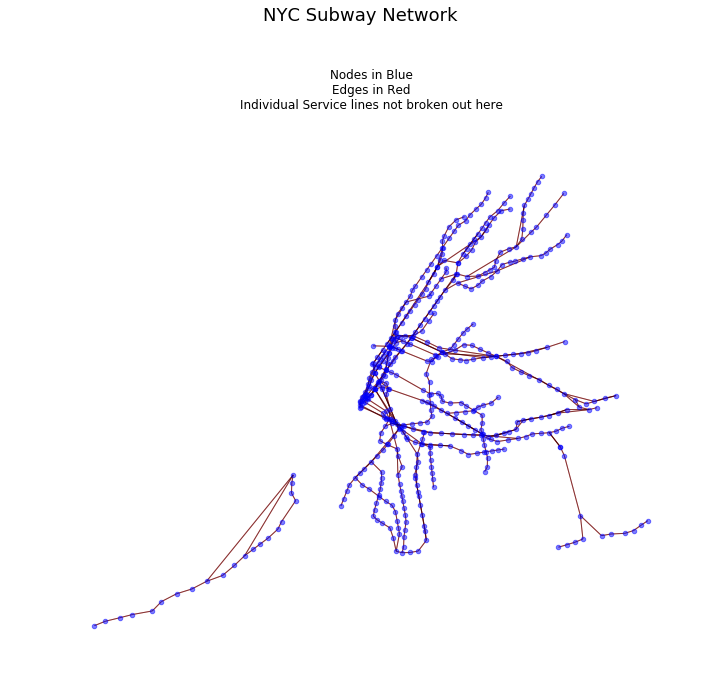

In [328]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )


In [329]:
nx.write_graphml(G1, "Subway_G1.graphml")

Let's verify G1 is valid when restored from file.

In [330]:
G1_test = nx.read_graphml("Subway_G1.graphml")

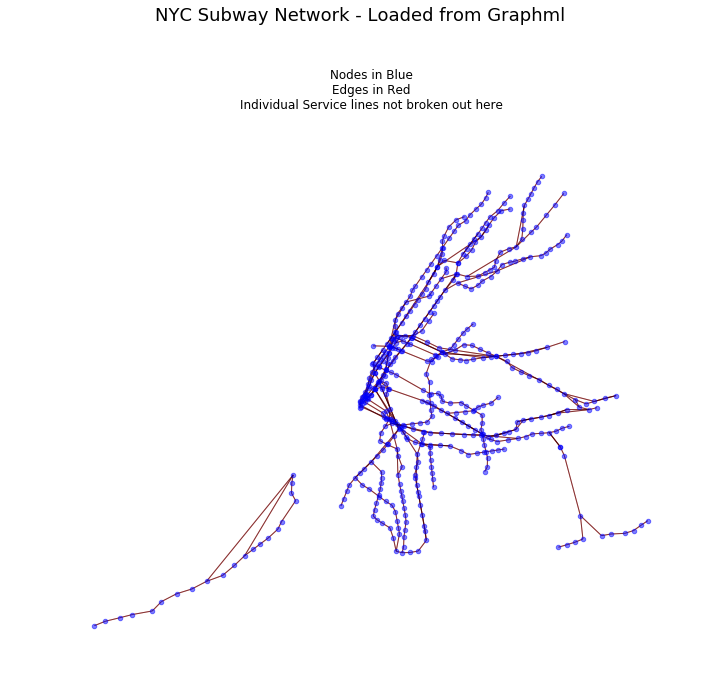

In [331]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Loaded from Graphml", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1_test, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1_test, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

If the above graph looks like the NYC subway, the graph was correctly saved to graphml file.

### Adding a Multigraph with Routes

We save a multigraph $G2$ in which the edges are assigned route attributes.

In [332]:
G2 = nx.MultiGraph()


for r, d in nodes_used.iterrows():
    G2.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_route_edges.iterrows():
    G2.add_edge(d['parent_a'], d['parent_b'], route_id = d['route_id'])

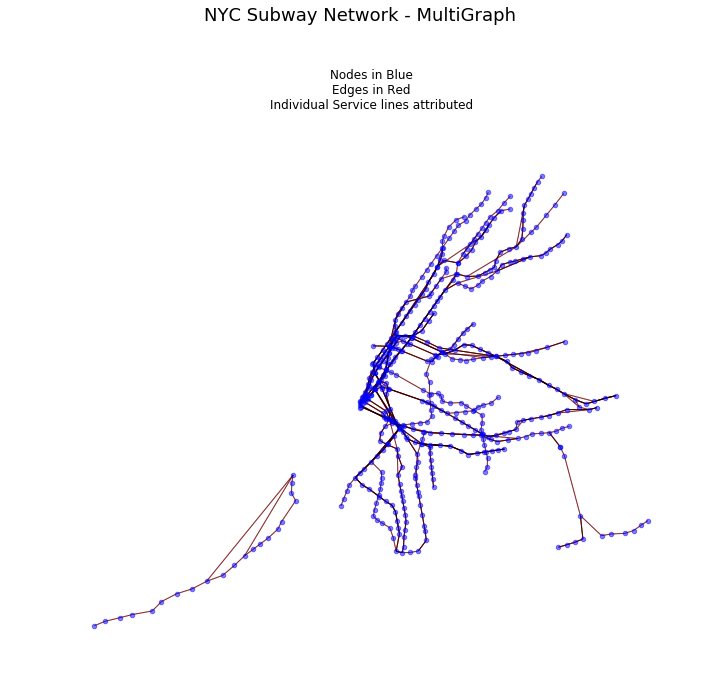

In [333]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - MultiGraph", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines attributed
""", fontsize=12)



nx.draw_networkx_edges(G2, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G2, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

In [334]:
nx.write_graphml(G2, "Subway_G2.graphml")

In [335]:
nodes_used[ nodes_used['stop_id'] == 'H04' ]

,stop_id,stop_name,stop_lat,stop_lon
350,H04,Broad Channel,40.608382,-73.815925


In [336]:
no_dups_res_edges[ 
                 (no_dups_res_edges["parent_a"] == '127') | ( no_dups_res_edges["parent_b"] == "127") 
                 ]

,parent_a,parent_b
90171,126,127
100402,127,128
100976,123,127


## Step 4: Linking Stations Together

The next step is to build a graph with enriched data to which we referred above as $G3$.  

### Defining Nodes

To build this graph we have to define the equivalence classes
of stations where two parent nodes $a$ and $b$ of graph $G1$ are considered equivalent $a \sim b$ iff $a$ can reach $b$ by walking through passageways after paying toll at $a$.  We will call an equivalent class of such parent nodes a **linked station**.

Most subway stations are define singleton equivalence classes.  But a few important stations are highly linked.  These typically occur in Manhattan where multiple train lines intersect.   At the linked stations, traffic is typically higher as riders often transfer between lines.  The top linked stations are:

* `Times Square-42 St` where 12 lines meet.  N, Q, R, W, S, 1, 2, 3, 7, A, C, E
* `Chambers Street, WTC, Park Place, Cortlandt` where 7 lines meet.  A, C, E, 2, 3, R, W
* `Fulton St` in Manhattan where 8 lines meet.  A, C, J, Z, 2, 3, 4, 5
* `Canal St` in Manhattan where 7 lines meet.  J, N, Q, R, W, Z, 6.

However, we define three nodes attributes for linked stations:

* `borough`  - each linked station has a well-defined borough because no parent nodes in each equivalence class always belong to one borough.
* `ridership` - the total number of riders is reported based on turnstile entrances with the entire linked station.

* no loops - no stops within a linked station are stops along the same route.  Otherwise, you would be able to both walk and ride between two stops within the subway system.

* `name` the linked station node identifier is ambiguous unless the equivalence class is a singleton.  
     +  For a singleton class, we define the linked station identifier to be the `stop_id` and the name to be the `stop_name`.
     +  For a linked station with multiple parent stations, we use the string `LINK_<xxx>` where <xxx> denotes the `stop_id` of the first station lexicographically.   Example:  `LINK_127` for the linked station at Times Square-42 Street composed of `127`, `725`, `902` , `A27`, `R16`.  We will use the stop name of the first stop in this eqivalence class:  `Times Sq-42 St`.
    
### Edges

We define an edge $e$ to exist in $G3$ between two linked stations $A$ and $B$ if there exist two parent stations $a$ , $b$ belonging to $A$ and $B$ respectively where $a$ is directly connected to $b$ as consecutive stops on some train route.  
    
It is easy to see that a path in $G3$ allows a rider to get from subway stop to another in New York City in a connected path with at most one transfer at each non-singleton linked station.
  
The code below implements $G3$ according to the description above.
    

Since the ridership data does not map to `stop_id` in the GTFS specification, we mapped each linked station manually to the GTFS parent stops by comparing the station names.  Unfortunately, GTFS station names are not unique.  There are many cases of stations which the same names.  The ridership linked stations identify all subways lines which allows us to manually compare the map between the data files.   
In rare cases, a train route passes through a station but the ridership dataset does not mention the train route.  For example, the N train passes through the R subway at Court Street/Borough Hall.



In [337]:
subway_links_file = "Subway_Links_2020.csv"
subway_links = pd.read_csv(subway_links_file)

subway_links = subway_links[ ['stop_id', 'stop_name', 'Borough', 'Rides2019', 'Rides2020', 'Linked', 'node_link', 'stop_lat', 'stop_lon' ]]
subway_links = subway_links.set_index('stop_id')
subway_links

,stop_name,Borough,Rides2019,Rides2020,Linked,node_link,stop_lat,stop_lon
stop_id,,,,,,,,
101,Van Cortlandt Park-242 St,Bx,2189109,980836,1,101,40.889248,-73.898583
103,238 St,Bx,1204095,588199,1,103,40.884667,-73.900870
104,231 St,Bx,2919305,1289691,1,104,40.878856,-73.904834
106,Marble Hill-225 St,M,1561844,754010,1,106,40.874561,-73.909831
107,215 St,M,527505,212402,1,107,40.869444,-73.915279
...,...,...,...,...,...,...,...,...
R44,86 St,B,3434888,1538353,1,R44,40.622687,-74.028398
S01,Franklin Av,B,4999385,1849090,3,LINK_239,40.680596,-73.955827
R45,Bay Ridge-95 St,B,1743441,740055,1,R45,40.616622,-74.030876


In [338]:
subway_links[ subway_links.index.isin(['140', 'H19', 'N12' ] ) ]

,stop_name,Borough,Rides2019,Rides2020,Linked,node_link,stop_lat,stop_lon
stop_id,,,,,,,,


The `subway_links` dataframe contains a map between active parent stops except for Staten Island stations and 3 omitted stations discussed earlier.   The set difference of the nodes in $G1 \setminus G2$ is the Staten Island stations as shown below.

In [339]:
subway_links["ratio20to19"] = subway_links["Rides2020"]/subway_links["Rides2019"]

subway_links["zRatio20to19"] = ( subway_links["ratio20to19"] - subway_links["ratio20to19"].mean() ) / subway_links["ratio20to19"].std(ddof= 0 )
    

In [340]:
subway_links.to_csv("Subway_Links_2020_zRatios.csv", index=True)

In [341]:
G3 = nx.Graph()

precision = 1

for r , d in subway_links.iterrows():
    link_node = d["node_link"]
    borough = d["Borough"]
    f19 = d["Rides2019"]
    f20 = d["Rides2020"]
    stop_name = d["stop_name"]
    lat = d["stop_lat"]
    lon = d["stop_lon"]
    
    delta_rides = f20 - f19
    
    ratio20to19 = d["ratio20to19"]
    zRatio20to19 = d["zRatio20to19"]
    
    if not link_node in G3.nodes():
        G3.add_node(link_node, borough = borough , 
                    rides2019 = f19, rides2020 = f20, 
                    delta_rides = delta_rides ,
                    ratio20to19 = ratio20to19 , 
                    zRatio20to19 = zRatio20to19 ,
                    link_name = stop_name ,
                    lat = lat, lon = lon
                   )

parent_nodes_used = subway_links.index
        

In [342]:
for r, ex in no_dups_res_edges.iterrows():
    
    if ex['parent_b'] in parent_nodes_used and ex['parent_a'] in parent_nodes_used:
        node_link1 =  subway_links.loc[ ex['parent_a'] , 'node_link' ]
        node_link2 =  subway_links.loc[ ex['parent_b'] , 'node_link' ]
        G3.add_edge( node_link1, node_link2 )


We see below that the linked subway graph has 420 stations and 541 edges.

In [343]:
(G3.number_of_nodes(), G3.number_of_edges())

(420, 541)

We plot the linked subway graph using the coordinates of first station of each linked node to represent the entire equivalence class of stops.

In [344]:
pos = {}
for n in G3.nodes():
     pos.update( { n :( G3.node[n]['lon'], G3.node[n]['lat'] ) } )

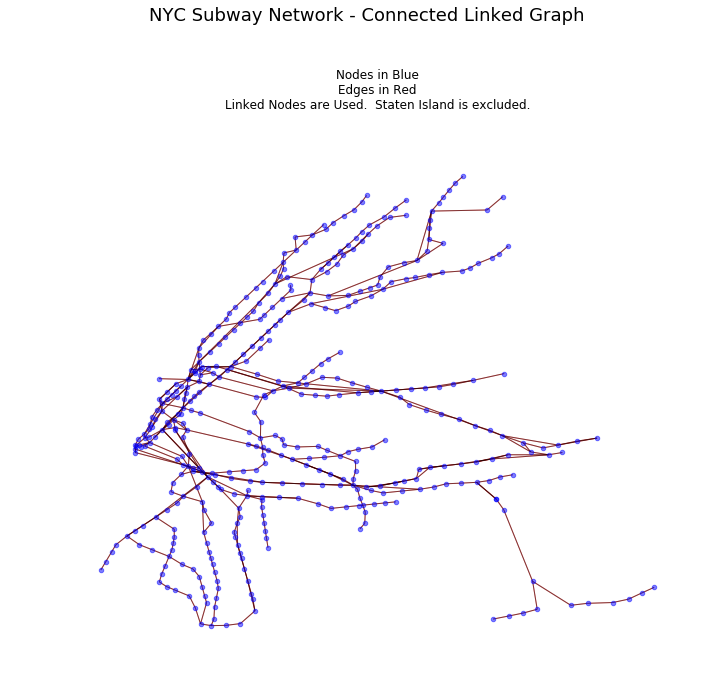

In [345]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Connected Linked Graph", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Linked Nodes are Used.  Staten Island is excluded.
""", fontsize=12)

nx.draw_networkx_edges(G3, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G3, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )


In [346]:
nx.number_connected_components(G3)

1

Now we write the linked graph to a graphml file for subsequent use.

In [347]:
nx.write_graphml(G3, "Subway_G3.graphml")

# Section 3: Ridership Analysis

The latest available subway ridership data from MTA is available at [Subway and bus ridership for 2020](https://new.mta.info/agency/new-york-city-transit/subway-bus-ridership-2020).
The datafile used is in Excel and lists ridership by aggregated station (https://new.mta.info/sites/default/files/inline-files/2020%20Subway%20Tables_ul.xlsx).   As the MTA points out, many stations are linked by transfer tunnels.   For example, the 14th Street A, C, E station is combined with the 8th Avenue L station since the rider can walk between the stations after crossing the turnstile at any one station.
These subtleties also affect our definition of the nodes.  

In [348]:
G3 = nx.read_graphml("Subway_G3.graphml")

## Centrality Measures

We compare eigenvector centrality, closeness centrality and degree centrality of the graph $G3$.
Each centrality measure is returned as a dictionary with the graph nodes as key.

Our key findings are that:

* Differences in closeness centrality seems to best approximate the proximity of the outer borough stops to Manhattan.
* Differences in degree centrality seem to be somewhat related to the outer boroughs.  The degree centrality is dispersed geographically through Manhattan, Queens and Brooklyn.
There seems to be some relationship to ridership changes.
* Differences in eigenvector centrality seems the least related to ridership changes.
* Borough average ridership changes are consistent with closeness centrality differences.   Ridership declines are proportional to closeness centrality.  In Manhattan, we see the ridership declines are the largest and closeness centrality is the highest.



In [349]:
#eigen_centrality = nx.eigenvector_centrality( G3)
#degree_centrality = nx.degree_centrality(G3)
#closeness_centrality = nx.closeness_centrality(G3)

In [350]:
#zRatios = nx.get_node_attributes(G3, 'zRatio20to19')
#borough = nx.get_node_attributes(G3, 'borough')
#link_name = nx.get_node_attributes(G3, 'link_name' )
df_zRatios     = pd.DataFrame.from_dict(nx.get_node_attributes(G3, 'zRatio20to19') ,     orient = 'index', columns = ['zRatios'] )
df_borough     = pd.DataFrame.from_dict(nx.get_node_attributes(G3, 'borough') ,     orient = 'index', columns = ['borough'] )
df_link_name   = pd.DataFrame.from_dict(nx.get_node_attributes(G3, 'link_name' ) ,   orient = 'index', columns = ['link_name'] )
df_ratio20to19 = pd.DataFrame.from_dict(nx.get_node_attributes(G3, 'ratio20to19'), orient = 'index' , columns = ['ratio20to19'] )


In [351]:
df_eigen     = pd.DataFrame.from_dict(nx.eigenvector_centrality( G3), orient='index', columns = ['eigenvector'])
df_degree    = pd.DataFrame.from_dict(nx.degree_centrality(G3), orient='index', columns = ['degree'])
df_closeness = pd.DataFrame.from_dict(nx.closeness_centrality(G3), orient='index', columns = ['closeness'])


We merge the centrality measures and the graph node attributes into a single dataframe indexed by the stop_id of each linked station below.

In [352]:
from functools import reduce

data_frames = [df_zRatios, df_borough, df_link_name, df_ratio20to19, df_eigen, df_degree, df_closeness]

df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_frames)

df_merged.head()

,zRatios,borough,link_name,ratio20to19,eigenvector,degree,closeness
101,0.379863,Bx,Van Cortlandt Park-242 St,0.448053,2.093829e-08,0.002387,0.052857
103,0.833212,Bx,238 St,0.488499,9.882683e-08,0.004773,0.055800
104,0.309557,Bx,231 St,0.441780,4.455047e-07,0.004773,0.059072
106,0.768989,M,Marble Hill-225 St,0.482769,2.003755e-06,0.004773,0.062734
107,-0.128995,M,215 St,0.402654,9.011107e-06,0.004773,0.066858


The table below shows the average level of decline in ridership by borough across all stations.
We see that Manhattan stations had the largest decline in ridership and the Bronx had the least decline.
Manhattan ridership in 2020 fell to 35.45% of its 2019 levels.  By comparison, Bronx fell to 48% of 2019 levels.
Brooklyn (43%) and Queens (45%) were still a far step from Manhattan.

In [353]:
df_merged.groupby('borough').mean()

,zRatios,ratio20to19,eigenvector,degree,closeness
borough,,,,,
B,0.206144,0.432554,0.003564,0.006005,0.090687
Bx,0.726828,0.479008,0.000361,0.005388,0.080253
M,-0.668200,0.354548,0.052679,0.006959,0.110189
Q,0.413854,0.451085,0.004351,0.005844,0.084374


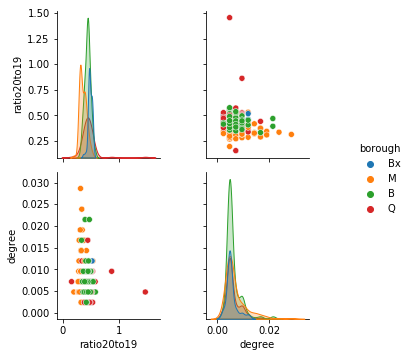

In [354]:
import seaborn as sns

sns.pairplot(df_merged[['ratio20to19',  'degree', 'borough']], hue="borough")

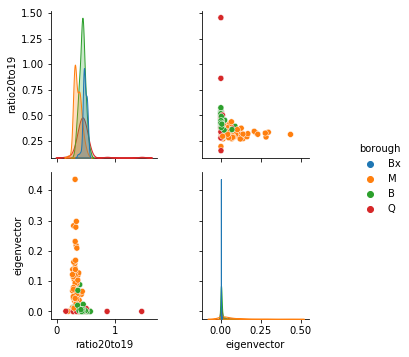

In [355]:
sns.pairplot(df_merged[['ratio20to19', 'eigenvector',  'borough']], hue="borough")

## Closeness Centrality

The pair plots below clearly show that the Ratio of changes in ridership are well differentiated by Borough.

*  In the density plots below for closeness, we see that Manhattan has the highest closeness centrality and the lowest average ratio of 2020 to 2019 ridership.
This means that Manhattan ridership dropped the most of the borough.

*  Queens has the widest dispersion of closeness centrality and also a wider dispersion of ridership changes.

*  Bronx has the lowest average closeness centralit and the highest average level of ridership ratio (i.e. ridership stayed highest).




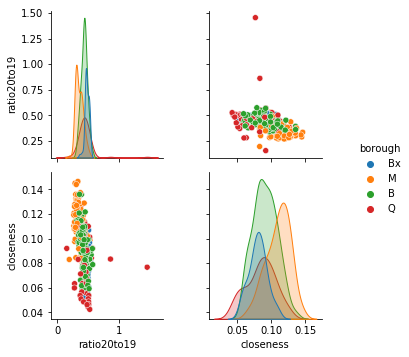

In [356]:
sns.pairplot(df_merged[['ratio20to19',  'closeness', 'borough']], hue="borough")

In [357]:
pos = {}
for n in G3.nodes():
     pos.update( { n :( G3.node[n]['lon'], G3.node[n]['lat'] ) } )

In [358]:
closeness_centrality = np.fromiter(nx.closeness_centrality(G3).values(), float)
degree_centrality = np.fromiter(nx.degree_centrality(G3).values(), float )
eigen_centrality = np.fromiter(nx.eigenvector_centrality(G3).values(), float)

ratios20to19 = np.fromiter( nx.get_node_attributes(G3, 'ratio20to19').values(), float )

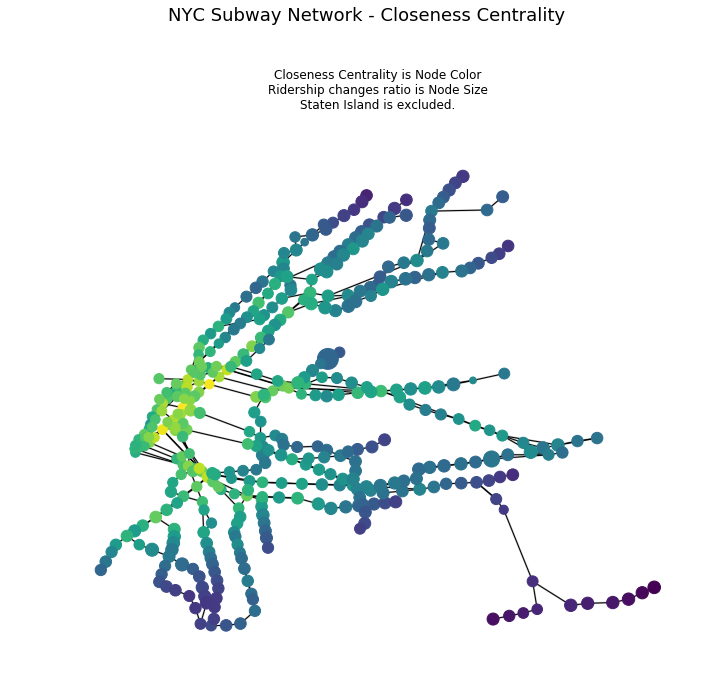

In [359]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Closeness Centrality", y = 1.05 ,fontsize= 18)

plt.title("""Closeness Centrality is Node Color
Ridership changes ratio is Node Size
Staten Island is excluded.
""", fontsize=12)

nx.draw_networkx_edges(G3, pos = pos, 
                       width = 2, 
                       edge_color = 'gray', 
                       alpha = 0.5 )

nx.draw(G3, pos = pos ,   
        with_labels = False ,
        alpha = 1 ,
        node_size = ratios20to19 * 3e2, 
        node_color = closeness_centrality )


In the graph plot below, we see that eigenvector centrality is highly concentrated in Manhattan but some central stations in Brooklyn.
It does not have great explanatory power or variation for outlying stations.

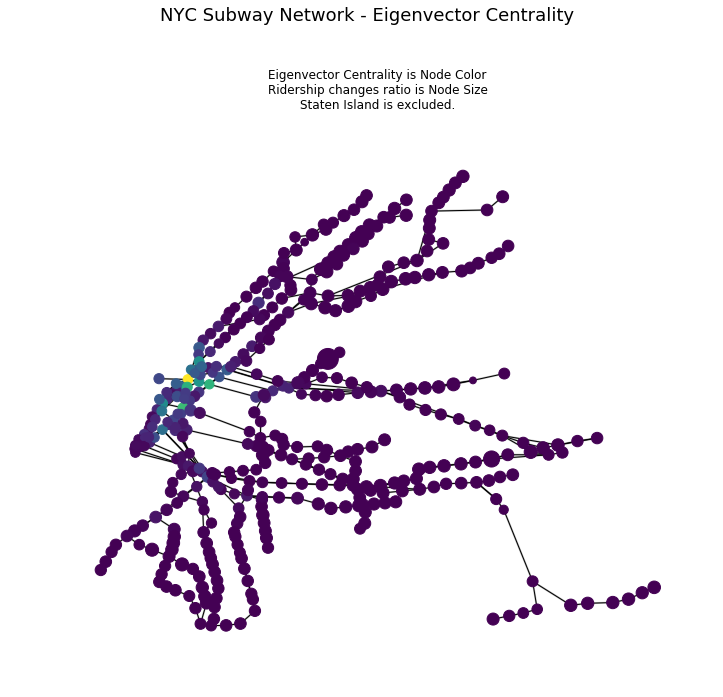

In [360]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Eigenvector Centrality", y = 1.05 ,fontsize= 18)

plt.title("""Eigenvector Centrality is Node Color
Ridership changes ratio is Node Size
Staten Island is excluded.
""", fontsize=12)

nx.draw_networkx_edges(G3, pos = pos, 
                       width = 2, 
                       edge_color = 'gray', 
                       alpha = 0.5 )

nx.draw(G3, pos = pos ,   
        with_labels = False ,
        alpha = 1 ,
        node_size = ratios20to19 * 3e2, 
        node_color = eigen_centrality )

Degree centrality seems to be dispersed in the city.  There are transfer points dispersed through the city where train lines meet.
This does not imply a lot about ridership declines except where stations in Manhattan allow more transfer typically than in outer boroughs.

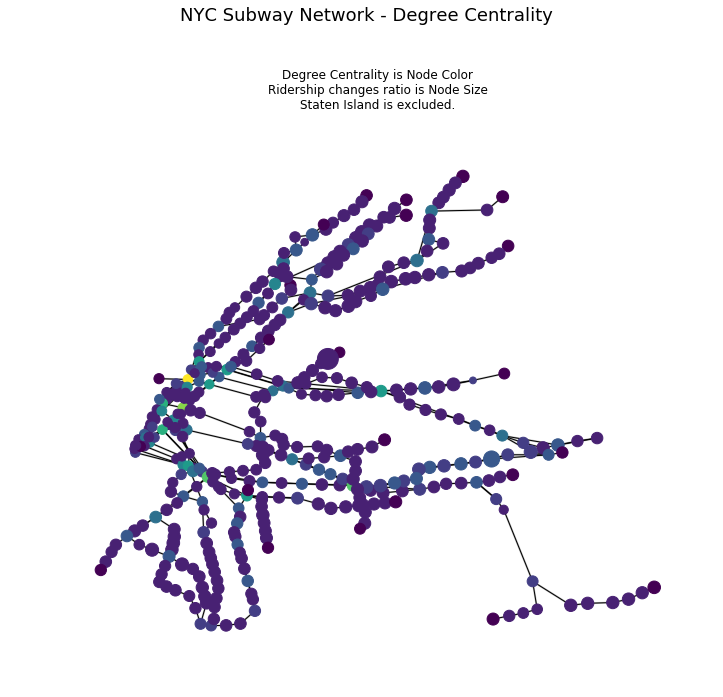

In [361]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Degree Centrality", y = 1.05 ,fontsize= 18)

plt.title("""Degree Centrality is Node Color
Ridership changes ratio is Node Size
Staten Island is excluded.
""", fontsize=12)

nx.draw_networkx_edges(G3, pos = pos, 
                       width = 2, 
                       edge_color = 'gray', 
                       alpha = 0.5 )

nx.draw(G3, pos = pos ,   
        with_labels = False ,
        alpha = 1 ,
        node_size = ratios20to19 * 3e2, 
        node_color = degree_centrality )

### Discussion

Our results suggest clearly that network centrality does matter.   Stations far from the center of New York city have the lowest closeness centrality.
These remote stations are associated with poorer neighborhoods with lower median household incomes, longer commute times and a higher proportion of workers in jobs that don't allow remote telework.
These jobs often require commuting by subway even if times of crisis such as the Covid-19 pandemic.  Our data is strongly supported by anecdotal evidence such as the New York Times article of Jan 17, 2022 which argued that ridership is surging most due to the socioeconomic differences in the outer boroughs.

https://www.nytimes.com/2022/01/17/nyregion/nyc-subway-ridership.html

>Stations in lower-income areas in Brooklyn, Queens and Upper Manhattan, where residents are less likely to be able to work from home and typically depend more on public transit, have rebounded far faster than stations in office-heavy sections of Manhattan, including some that were once the busiest in the system, where many workers are still able to work remotely.

We conclude with a visual exhibit of the subway system generated using the network visualization tool Gephi using the $G3$ graph data.   It shows the centrality measures coincide with borough structure.   It is not surprisingly that ridership changes are correlated with borough.   It is less clearly that centrality causes the ridership changes.  Perhaps these are both driven by underlying causal factors.

![Detailed Image](gephi_ss_betweenness_detail.png)

# Section 4: Income Analysis 

We will analyze the network centrality of the New York City Subway system by categorizing each station based on the median household income of the station's surrounding area as defined below.

Income brackets based on New York, New Jersey, Pennsylvania household income quartiles in 2021:
* **Low:** less than or equal to \\$36,000
* **Medium:** Between \\$36,001 and \$78,000
* **High:** Between \\$78,001 and \$150,000
* **Very high:** greater than \\$150,000  
Source: https://dqydj.com/income-by-city/

Household Median Income is available from [censusreporter.org](www.censusreporter.org) from the US Census Bureau's American Community Survey (ACS) with 2015-2019 median income inflation adjusted to 2019 dollars.   We obtain the household median income (field B19013) as the census tract level.   For each subway station, we assign the median household income of the census tract containing the station based on the geocoded location provided by the GTFS dataset.

A single datafile in `geojson` format for the entire NYC metropolitan area encompasses all subway stations.  The map partitions the city at census tract level and provides the household median income.
This evaluation focuses on the household median income of those living near a given subway stop in order to ascertain a better understanding of wealth distribution across New York City in relationship to not only access to the subway system but also ease of access across the subway system.

The network centrality metrics for the analysis will be degree centrality, closeness centrality, betweenness centrality, and eigenvector centrality.

#### Calculate centrality measures using Networkx library

In [362]:
deg = nx.degree(G3)
c = nx.closeness_centrality(G3)
b = nx.betweenness_centrality(G3)
e = nx.eigenvector_centrality(G3)

#### Using the G3 network and converting to a Pandas dataframe

In [363]:
df_stations = pd.DataFrame.from_dict(dict(G3.nodes(data=True)), orient='index')
df_stations = df_stations.rename_axis('node_link').reset_index()

In [364]:
df_stations.head(5)

,node_link,borough,rides2019,rides2020,delta_rides,ratio20to19,zRatio20to19,link_name,lat,lon
0,101,Bx,2189109,980836,-1208273,0.448053,0.379863,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,Bx,1204095,588199,-615896,0.488499,0.833212,238 St,40.884667,-73.900870
2,104,Bx,2919305,1289691,-1629614,0.441780,0.309557,231 St,40.878856,-73.904834
3,106,M,1561844,754010,-807834,0.482769,0.768989,Marble Hill-225 St,40.874561,-73.909831
4,107,M,527505,212402,-315103,0.402654,-0.128995,215 St,40.869444,-73.915279


#### Functions to lookup the household median income for a latitude and longitude point based on the inclusion with a census tract from 2019
From the household median income, derive the income category based on quartiles for New York City in 2019

In [365]:
# How to find point inside geojson format
# https://stackoverflow.com/questions/57727739/how-to-determine-if-a-point-is-inside-a-polygon-using-geojson-and-shapely

# Open the geojson file and load into notebook
with open('acs2019_5yr_B19013_14000US36047053700/acs2019_5yr_B19013_14000US36047053700.geojson', 'r') as file:
    nyc_tract_data = json.load(file)
        
# Order: Longitude, latitude
# For a given long, lat pair in NYC, return the household median income
# Return -1.0 if the income value is missing
def getHouseholdMedianIncomeInNycByPoint(point):
    income = -1.0
    for feature in nyc_tract_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # Entire NYC in geojson, make sure to ignore
            if feature['properties']['name'] != "New York, NY":
                income = feature['properties']['B19013001']
    if pd.isna(income):
        income = -1.0
    return income

# For a row from the dataset get the household median income by using the long, lat
def getHouseholdMedianIncomeInNycByRow(row):
    return getHouseholdMedianIncomeInNycByPoint(Point(row['lon'], row['lat']))

# For a row from the dataset get the household median income, income category by using the long, lat
def getIncomeAndIncomeCategoryInNycByRow(row):
    income = getHouseholdMedianIncomeInNycByPoint(Point(row['lon'], row['lat']))

    # https://furmancenter.org/stateofthecity/view/citywide-and-borough-data
    # 2019 median hh income
    # BK: Median household income in 2019 was $68,080
    # BX: Median household income in 2019 was $42,140
    # MN: Median household income in 2019 was $95,250
    # QU: Median household income in 2019 was $74,960
    # SI: Median household income in 2019 was $91,360
    
    # If income is missing, impute the borough median value
    if income < 0.0:
        if row['borough'] == 'B':
            income = 68080.0
        elif row['borough'] == 'Q':
            income = 74960.0
        elif row['borough'] == 'M':
            income = 95250.0
        elif row['borough'] == 'Bx':
            income = 42140.0
    
    # Bucket income
    #Low: less than or equal to $36,000
    #Medium: Between $36,001 and $78,000
    #High: Between $78,001 and $150,000
    #Very high: greater than $150,000
    incomeCategory = "NONE"
    if income < 0.0:
        incomeCategory = "NA"
    elif income <= 36000:
        incomeCategory = "LOW"
    elif income <= 78000:
        incomeCategory = "MED"
    elif income <= 150000:
        incomeCategory = "HIGH"
    elif income > 150000:
        incomeCategory = "VHIGH"
    else:
        incomeCategory = "ERROR"
        
    return income, incomeCategory

Call function to retrieve income and income category and bind columns to Pandas dataframe

In [366]:
res = df_stations.apply(lambda row: getIncomeAndIncomeCategoryInNycByRow(row), axis=1)
df = pd.DataFrame(res.tolist())
df.columns=['hh_med_income', 'income_category']
df_stations_with_income = pd.concat([df_stations, df], axis=1)
#df_stations_with_income.head(10)

Add columns for the four centrality measures

In [367]:
df_stations_with_income['degrees'] = df_stations_with_income['node_link'].map(deg)
df_stations_with_income['btwn_cent'] = df_stations_with_income['node_link'].map(b)
df_stations_with_income['clos_cent'] = df_stations_with_income['node_link'].map(c)
df_stations_with_income['eign_cent'] = df_stations_with_income['node_link'].map(e)
#df_stations_with_income.head(10)

As a baseline for understanding the distribution of wealth, the below plot shows the household median income per subway station by the borough. The x-axis of Income Category is common among the following plots.

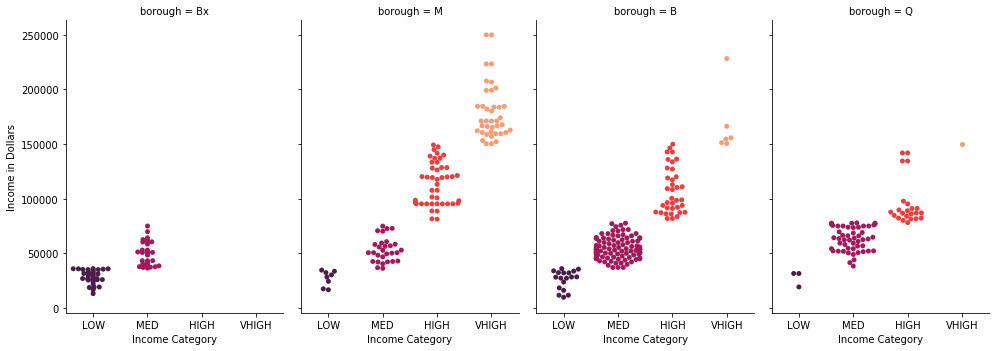

In [368]:
sns.catplot(x='income_category', 
            y='hh_med_income', 
            data=df_stations_with_income, 
            col='borough', 
            order=['LOW', 'MED', 'HIGH', 'VHIGH'],
            aspect=.7, 
            kind="swarm",
            palette='rocket').set(
                   xlabel='Income Category', 
                   ylabel='Income in Dollars');

## Degree Centrality

The degree centrality measures the number of neighbors for each node, a straightforward measure of connectedness in a network.

First, we plot a histogram of the distribution of degree count.

In [369]:
degrees = pd.DataFrame.from_dict(deg, orient='index')
degrees.columns = ['num_deg']

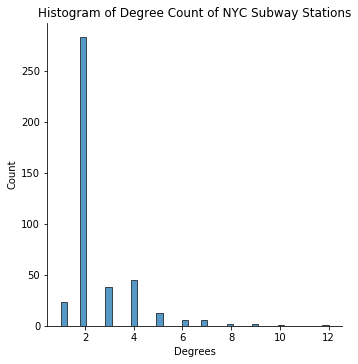

In [370]:
sns.displot(degrees, x='num_deg').set(title='Histogram of Degree Count of NYC Subway Stations', xlabel='Degrees', ylabel='Count');

The histogram shows a range of degrees from 1 to 12. As anticipated, the most common degree count is 2, indicating most stations are connected to two other stations.

### Degree Centrality by Income Category

The plot below shows the distribution of degree count per subway station across the 4 income categories. The boroughs are interspersed across the categories and denoted by color according to the legend. The higher degree counts do tend to coincide with the greater household median incomes. To be expected, all income categories have many counts of 2 given the nature of the subway routes.

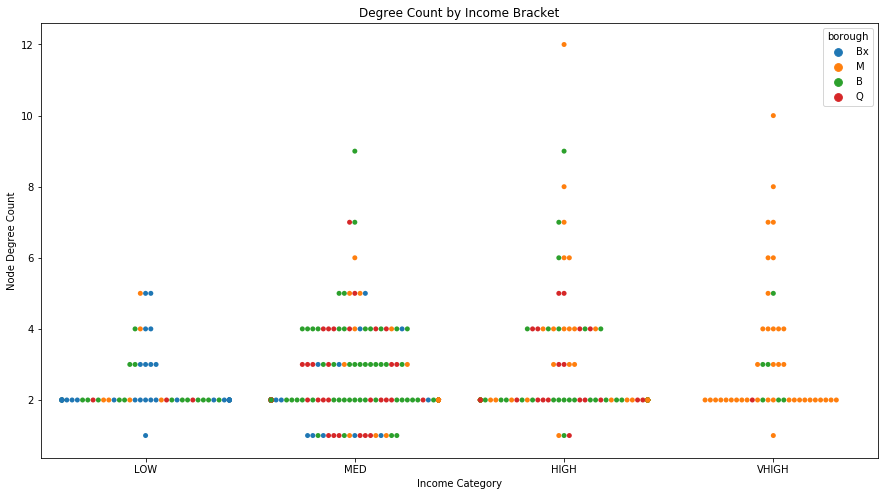

In [371]:
plt.figure(figsize=(15,8))
sns.swarmplot(x='income_category', 
              y='degrees', 
              data=df_stations_with_income, 
              hue='borough', 
              order=['LOW', 'MED', 'HIGH', 'VHIGH']
             ).set(title='Degree Count by Income Bracket', 
                   xlabel='Income Category', 
                   ylabel='Node Degree Count');

#### Top 10 by Degree Count
The top 10 subway stations by degree count includes 7 high or very high income subway stations and just 3 in the medium income category.

In [372]:
df_stations_with_income[['link_name', 'borough', 'income_category', 'degrees']].sort_values(by=['degrees'], ascending=False).head(10)

,link_name,borough,income_category,degrees
24,Times Sq-42 St,M,HIGH,12
143,14 St-Union Sq,M,VHIGH,10
202,Broadway Junction,B,MED,9
69,Atlantic Av-Barclays Ctr,B,HIGH,9
29,14 St,M,VHIGH,8
147,Canal St,M,HIGH,8
73,Franklin Av-Medgar Evers College,B,MED,7
139,Grand Central-42 St,M,HIGH,7
192,Jay St-MetroTech,B,HIGH,7
156,74 St-Broadway,Q,MED,7


## Closeness Centrality

Closeness, or the inverse to the distance to others, is the first centrality metric to consider. The closenes centrality measure results in a number between 0 and 1, in which the higher the value, the lower average distance to the other nodes.

### Closeness Centrality by Income Category

The below swarmplot indicates a clear relationship between income category and the closeness centrality measure. The higher the income, the greater the closeness within the network.

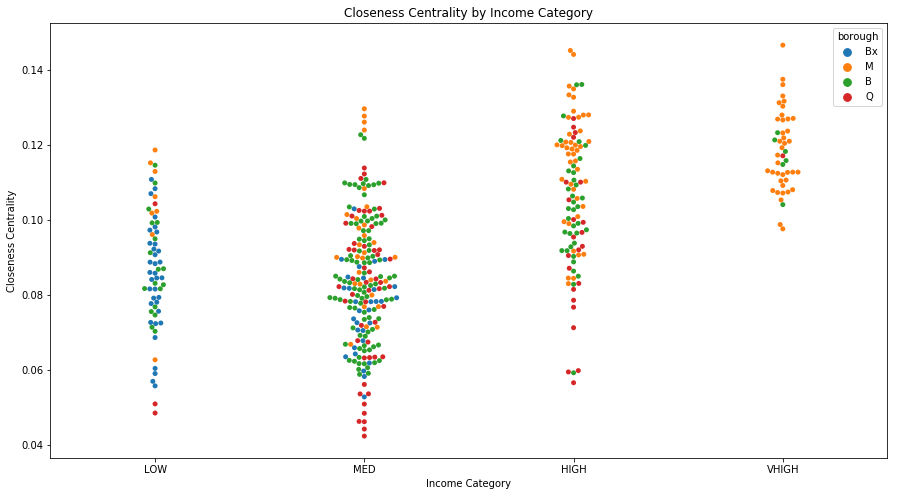

In [373]:
plt.figure(figsize=(15,8))
sns.swarmplot(x='income_category', 
              y='clos_cent', 
              data=df_stations_with_income, 
              hue='borough', 
              order=['LOW', 'MED', 'HIGH', 'VHIGH']
             ).set(title='Closeness Centrality by Income Category', 
                   xlabel='Income Category', 
                   ylabel='Closeness Centrality');

Given the closeness centrality measure provides the greatest distribution of the all metric results, we unpack the above plot by borough. The below visual separates the plots by borough which again reinforces that higher income has a correlation with a greater closeness measure across boroughs.

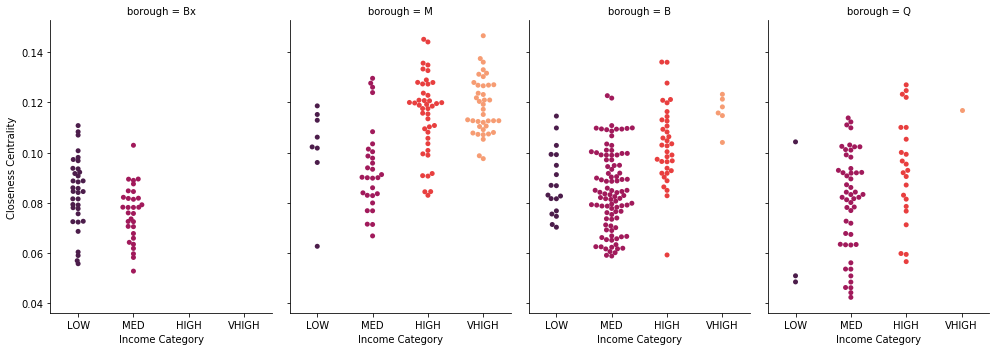

In [374]:
sns.catplot(x='income_category', 
            y='clos_cent', 
            data=df_stations_with_income, 
            col='borough', 
            order=['LOW', 'MED', 'HIGH', 'VHIGH'],
            aspect=.7, 
            kind='swarm',
            palette='rocket').set( 
                   xlabel='Income Category', 
                   ylabel='Closeness Centrality');

#### Top 10 by Closeness Centrality
The top 10 subway stations by closeness centrality includes 3 very high and 7 high income subway stations. Manhattan contains 8 of the top 10, while the remaining 2 are located in Brooklyn.

In [375]:
df_stations_with_income[['link_name', 'borough', 'income_category', 'clos_cent']].sort_values(by=['clos_cent'], ascending=False).head(10)

,link_name,borough,income_category,clos_cent
143,14 St-Union Sq,M,VHIGH,0.146503
139,Grand Central-42 St,M,HIGH,0.145083
147,Canal St,M,HIGH,0.144036
137,59 St,M,VHIGH,0.137422
407,DeKalb Av,B,HIGH,0.136039
148,Brooklyn Bridge-City Hall,M,VHIGH,0.135995
69,Atlantic Av-Barclays Ctr,B,HIGH,0.135951
242,34 St-Herald Sq,M,HIGH,0.135599
24,Times Sq-42 St,M,HIGH,0.134857
145,Bleecker St,M,HIGH,0.133270


## Betweenness Centrality

The betweenness centrality attempts to identify boundary spanners. As the closeness centrality measure, the betweenness centarlity metric results in a number ranging from 0 to 1 with a higher value indicating a node connecting two or more otherwise disparate subcomponents of the graph. This measure often results in most nodes with small values as few nodes are likely to be boundary spanners.

### Betweenness Centrality by Income Category

The assumption of many low values bears out as only a few nodes have a betweenness centrality above 0.2. Of the 9 nodes above 0.2, only 1 occurs in a tract with low income while the other 8 fall in tracts of high or very high income. Unsurprisingly, 7 of the 9 nodes above 0.2 are located in Manhattan while the other 2 are located in Brooklyn.

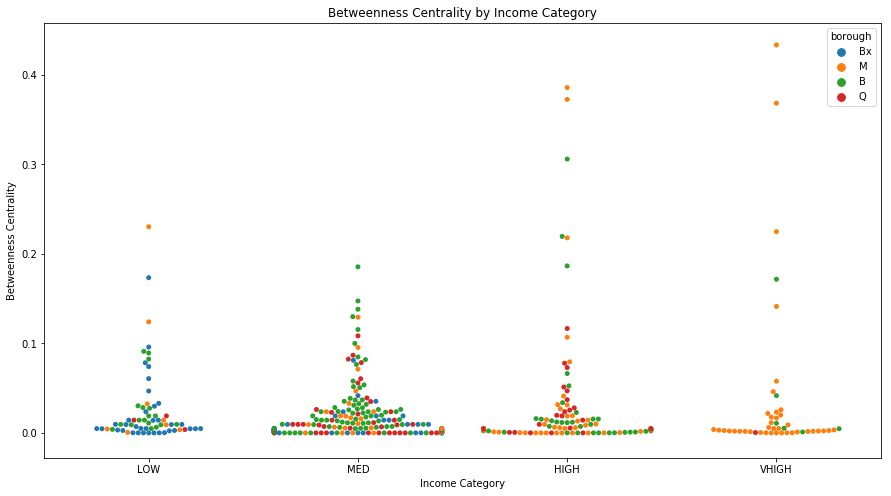

In [376]:
plt.figure(figsize=(15,8))
sns.swarmplot(x='income_category', 
              y='btwn_cent', 
              data=df_stations_with_income, 
              hue='borough', 
              order=['LOW', 'MED', 'HIGH', 'VHIGH']
             ).set(title='Betweenness Centrality by Income Category', 
                   xlabel='Income Category', 
                   ylabel='Betweenness Centrality');

#### Top 10 by Betweenness Centrality
The top 10 subway stations by betweenness centrality.

In [377]:
df_stations_with_income[['link_name', 'borough', 'income_category', 'btwn_cent']].sort_values(by=['btwn_cent'], ascending=False).head(10)

,link_name,borough,income_category,btwn_cent
143,14 St-Union Sq,M,VHIGH,0.433474
139,Grand Central-42 St,M,HIGH,0.385798
147,Canal St,M,HIGH,0.372560
137,59 St,M,VHIGH,0.368396
69,Atlantic Av-Barclays Ctr,B,HIGH,0.305938
129,125 St,M,LOW,0.230308
134,86 St,M,VHIGH,0.224835
192,Jay St-MetroTech,B,HIGH,0.219505
24,Times Sq-42 St,M,HIGH,0.217909
407,DeKalb Av,B,HIGH,0.186550


## Eigenvector Centrality

Eigenvector centrality measures the centrality of a node by using a weighted sum of centralities of the node's neighbors. The eigenvector centrality identifies nodes central to a network based on the centrality of the node's neighbors.

### Eigenvector Centrality by Income Category

Following a similar pattern of the closeness and betweenness centrality measures, the eigenvector centrality also shows the higher values occur for subway stations located in high or very High income tracts. Also, the higher values are more likely to occur in the Manhattan borough.

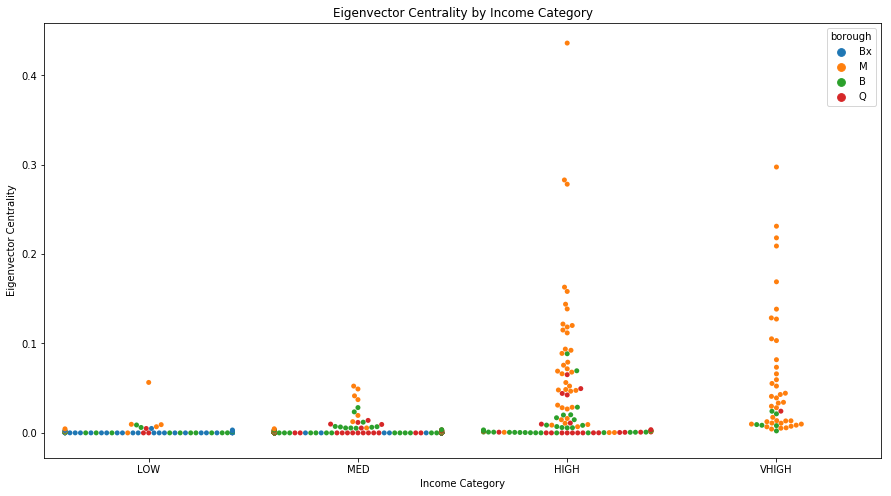

In [378]:
plt.figure(figsize=(15,8))
sns.swarmplot(x='income_category', 
              y='eign_cent', 
              data=df_stations_with_income, 
              hue='borough', 
              order=['LOW', 'MED', 'HIGH', 'VHIGH']
             ).set(title='Eigenvector Centrality by Income Category', 
                   xlabel='Income Category', 
                   ylabel='Eigenvector Centrality');

#### Top 10 by Eigenvector Centrality
The top 10 subway stations by eigenvector centrality includes 5 very high and 5 high income subway stations. All 10 are located in Manhattan.

In [379]:
df_stations_with_income[['link_name', 'borough', 'income_category', 'eign_cent']].sort_values(by=['eign_cent'], ascending=False).head(10)

,link_name,borough,income_category,eign_cent
24,Times Sq-42 St,M,HIGH,0.436050
143,14 St-Union Sq,M,VHIGH,0.297408
139,Grand Central-42 St,M,HIGH,0.282933
242,34 St-Herald Sq,M,HIGH,0.278198
167,5 Av,M,VHIGH,0.231203
22,59 St-Columbus Circle,M,VHIGH,0.218172
29,14 St,M,VHIGH,0.209019
188,W 4 St-Wash Sq,M,VHIGH,0.169014
184,50 St,M,HIGH,0.163032
147,Canal St,M,HIGH,0.158227


## Distance Evaluation
The New York City subway station with the highest number of neighbors is the Times Sq-42 St station with a degree count of 12. This subway station has the 9th highest closeness centrality and 9th highest betweenness centrality along with the greatest eigenvector centrality. Informally, this station could considered the central node of the entire subway system. The following plot evaluates the physical distance in miles of each subway station from the centrol node plotted against the household median income.

In [380]:
center_lon = df_stations_with_income[df_stations_with_income['link_name']=='Times Sq-42 St'].lon.item()
center_lat = df_stations_with_income[df_stations_with_income['link_name']=='Times Sq-42 St'].lat.item()

In [381]:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
def calculateDistanceFromRowInMiles(row):
    return calculateDistanceFromPointInMiles(center_lat, center_lon, row['lat'], row['lon'])

def calculateDistanceFromPointInMiles(orig_lat, orig_lon, dest_lat, dest_lon):
    orig = (orig_lat, orig_lon)
    dest = (dest_lat, dest_lon)
    return (geopy.distance.distance(orig, dest).miles)

In [382]:
res = df_stations_with_income.apply(lambda row: calculateDistanceFromRowInMiles(row), axis=1)
df = pd.DataFrame(res.tolist())
df.columns=['dist_from_tsquare']
df_stations_with_income_ts = pd.concat([df_stations_with_income, df], axis=1)
#df_stations_with_income_ts.head()

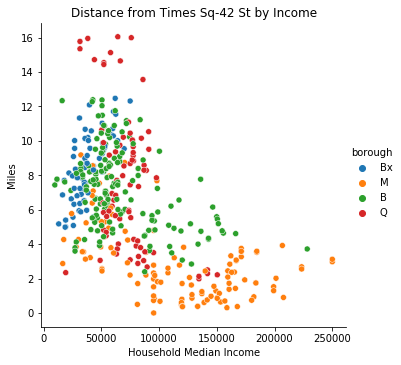

In [383]:
sns.relplot(x="hh_med_income", 
            y="dist_from_tsquare", 
            hue="borough", 
            data=df_stations_with_income_ts).set(
                   title='Distance from Times Sq-42 St by Income',
                   xlabel='Household Median Income', 
                   ylabel='Miles');

The above plot captures the distances for Manhattan borough stations are close while Queens has the farthest stations from Times Sq-42 St. Given the higher median incomes are mostly concentrated in Manhattan, the plot does show that higher incomes tend to be closer to the Times Sq-42 St station while lower incomes are farther away. This plot supports the common belief that outer-borough individuals have lower incomes while those in centeral Manhattan tend to have higher incomes.

### Discussion
afadsf

# Section 5: Conclusion

In [384]:
1+3

3